# Цель лабораторной работы
Изучить способы предварительной обработки данных для&nbsp;дальнейшего формирования моделей<cite data-cite="ue:lab3"></cite>.

# Задание
Требуется<cite data-cite="ue:lab3"></cite>:

1. Выбрать набор данных (датасет), содержащий категориальные признаки и пропуски в&nbsp;данных. Для&nbsp;выполнения следующих пунктов можно использовать несколько различных наборов данных.
2. Для&nbsp;выбранного датасета (датасетов) на основе материалов [лекции](https://github.com/ugapanyuk/ml_course/blob/master/common/notebooks/missing/handling_missing_norm.ipynb) решить следующие задачи:
    * обработку пропусков в данных;
    * кодирование категориальных признаков;
    * масштабирование данных.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.impute
import sklearn.preprocessing

# Enable inline plots
%matplotlib inline

# Set plot style
sns.set(style="ticks")

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

Для&nbsp;выполнения данной лабораторной работы возьмём набор данных по&nbsp;приложениям в&nbsp;Google Play Store<cite data-cite="kg:play"></cite>:

In [3]:
data = pd.read_csv("googleplaystore.csv")

Посмотрим на&nbsp;эти наборы данных:

In [4]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [6]:
data.shape

(10841, 13)

## Обработка пропусков в&nbsp;данных

Найдем все пропуски в&nbsp;данных:

In [7]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               1
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Очевидно, что мы будем работать с&nbsp;колонкой `Rating`.

Самый простой вариант — заполнить пропуски нулями:

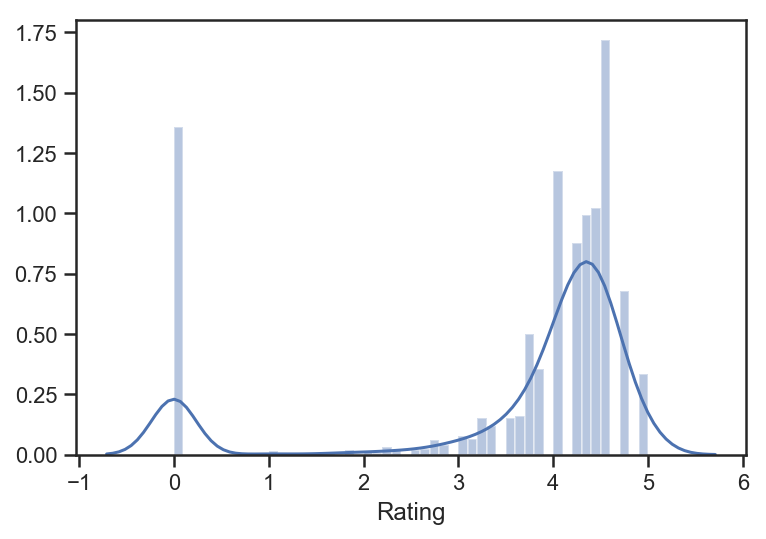

In [8]:
sns.distplot(data["Rating"].fillna(0));

Видно, что в&nbsp;данной ситуации это приводит к&nbsp;выбросам. Логичнее было бы приложениям без&nbsp;рейтинга присваивать средний рейтинг:

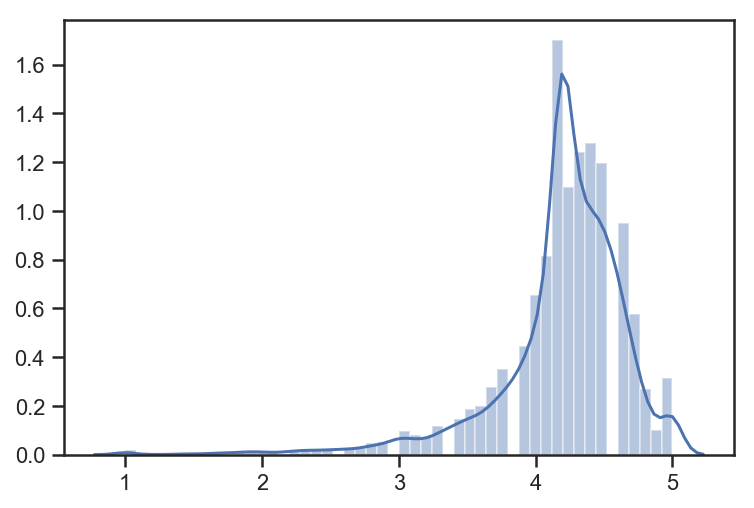

In [9]:
mean_imp = sklearn.impute.SimpleImputer(strategy="mean")
mean_rat = mean_imp.fit_transform(data[["Rating"]])
sns.distplot(mean_rat);

Попробуем также медианный рейтинг и самый частый рейтинг:

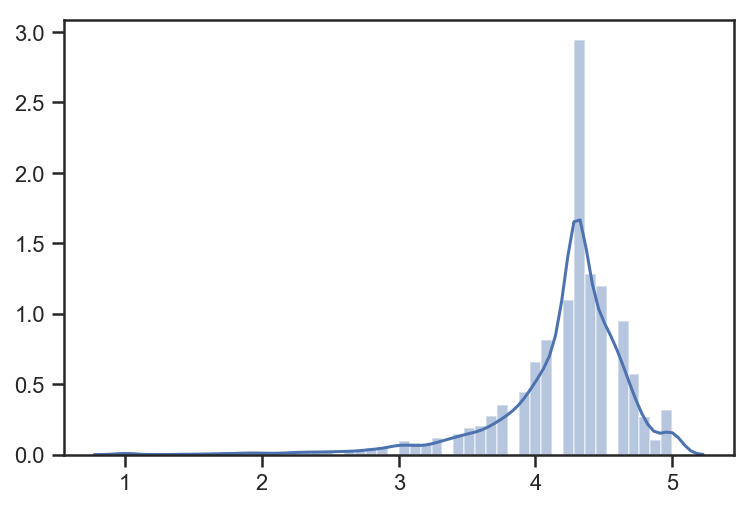

In [10]:
med_imp = sklearn.impute.SimpleImputer(strategy="median")
med_rat = med_imp.fit_transform(data[["Rating"]])
sns.distplot(med_rat);

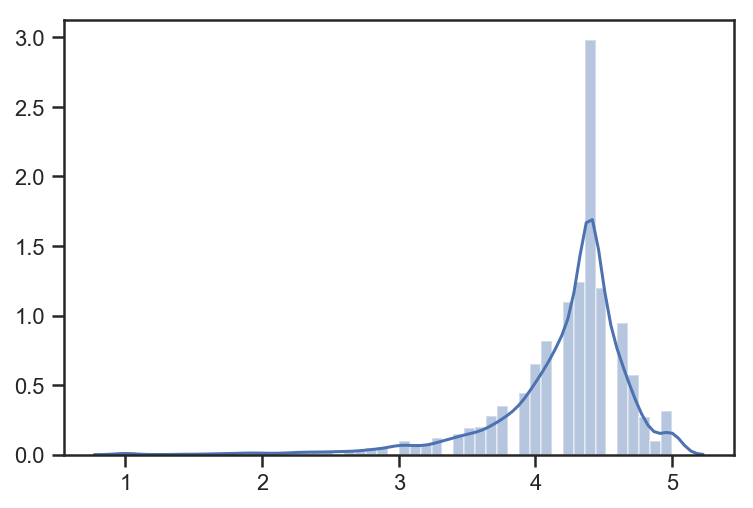

In [11]:
freq_imp = sklearn.impute.SimpleImputer(strategy="most_frequent")
freq_rat = freq_imp.fit_transform(data[["Rating"]])
sns.distplot(freq_rat);

Видно, что самый близкий к&nbsp;нормальному распределению график дало обычное среднее значение. Остановимся на&nbsp;нём:

In [12]:
data["Rating"] = mean_rat

## Кодирование категориальных признаков

Рассмотрим колонку `Type`:

In [13]:
types = data["Type"].dropna().astype(str)
types.value_counts()

Free    10040
Paid      800
Name: Type, dtype: int64

Выполним кодирование категорий целочисленными значениями:

In [14]:
le = sklearn.preprocessing.LabelEncoder()
type_le = le.fit_transform(types)
print(np.unique(type_le))
le.inverse_transform(np.unique(type_le))

[0 1]


array(['Free', 'Paid'], dtype=object)

Выполним кодирование категорий наборами бинарных значений:

In [15]:
type_oh = pd.get_dummies(types)
type_oh.head()

,Free,Paid
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [16]:
type_oh[type_oh["Paid"] == 1].head()

,Free,Paid
234,0,1
235,0,1
290,0,1
291,0,1
427,0,1


## Масштабирование данных

Для&nbsp;начала попробуем обычное MinMax-масштабирование:

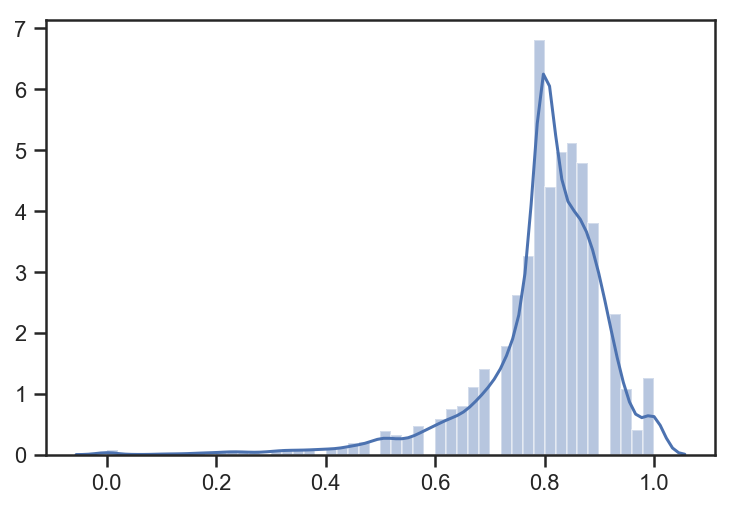

In [17]:
mm = sklearn.preprocessing.MinMaxScaler()
sns.distplot(mm.fit_transform(data[["Rating"]]));

Результат вполне ожидаемый и вполне приемлемый. Но попробуем и другие варианты, например, масштабирование на&nbsp;основе Z-оценки:

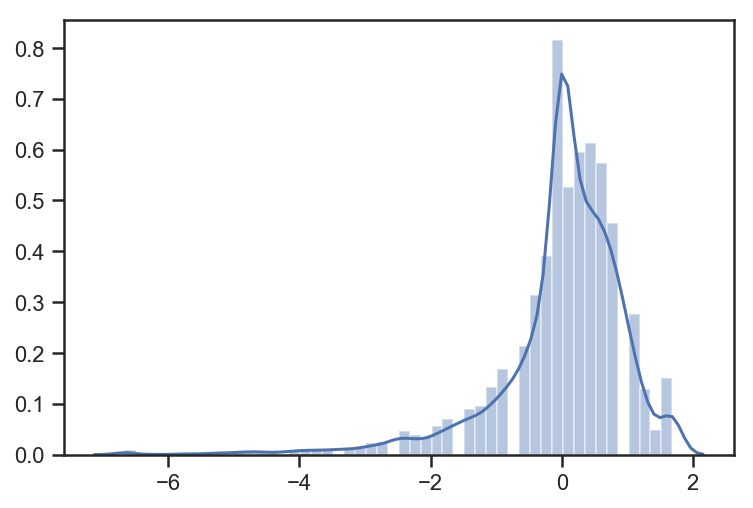

In [18]:
ss = sklearn.preprocessing.StandardScaler()
sns.distplot(ss.fit_transform(data[["Rating"]]));

Также результат ожидаемый, но его применимость зависит от&nbsp;дальнейшего использования.

Также была опробована нормализация данных, но единственным результатом была ошибка `LinAlgError: singular matrix`. С&nbsp;чем она связана не&nbsp;до&nbsp;конца очевидно, вероятно, метод `sklearn.preprocessing.Normalizer` плохо рассчитан на&nbsp;одноколоночные данные.